In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [70]:
train = pd.read_csv('/work/home/ybchae/aimers/aimers_data/train.csv').drop(columns=['ID'])
test = pd.read_csv('/work/home/ybchae/aimers/aimers_data/test.csv').drop(columns=['ID'])
train.shape, test.shape

((256351, 68), (90067, 67))

In [71]:
train = train[~((train["이식된 배아 수"] == 0) & (train["임신 성공 여부"] == 1))]
train.shape

(256321, 68)

In [72]:
train['임신 성공 여부'].value_counts()

0    190123
1     66198
Name: 임신 성공 여부, dtype: int64

In [73]:
drop_columns = ['임신 시도 또는 마지막 임신 경과 연수', '난자 해동 경과일', '배란 유도 유형', '배아 해동 경과일', '불임 원인 - 여성 요인', '난자 채취 경과일']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256321, 62), (90067, 61))

In [74]:
PGS_PGD_col_list = ['착상 전 유전 검사 사용 여부','착상 전 유전 진단 사용 여부', 'PGD 시술 여부', 'PGS 시술 여부']
for col in PGS_PGD_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

train['PGS'] = train['착상 전 유전 검사 사용 여부'] + train['PGS 시술 여부'] 
test['PGS'] = test['착상 전 유전 검사 사용 여부'] + test['PGS 시술 여부'] 

train['PGD'] = train['착상 전 유전 진단 사용 여부'] + train['PGD 시술 여부']
test['PGD'] = test['착상 전 유전 진단 사용 여부'] + test['PGD 시술 여부']

train.drop(columns=PGS_PGD_col_list, inplace=True)
test.drop(columns=PGS_PGD_col_list, inplace=True)

train['PGS'].value_counts(), train['PGD'].value_counts()

(0.0    253605
 2.0      1928
 1.0       788
 Name: PGS, dtype: int64,
 0.0    253129
 2.0      2178
 1.0      1014
 Name: PGD, dtype: int64)

In [75]:
train['난자 출처'] = train['난자 출처'].replace('알 수 없음','본인 제공')
test['난자 출처'] = test['난자 출처'].replace('알 수 없음','본인 제공')

train['정자 출처'] = train['정자 출처'].replace('배우자 및 기증 제공','배우자 제공')
test['정자 출처'] = test['정자 출처'].replace('배우자 및 기증 제공','배우자 제공')

# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만43-44세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만43-44세')

train['시술 당시 나이'].value_counts(), test['시술 당시 나이'].value_counts()

(만18-34세    102463
 만35-37세     57777
 만38-39세     39242
 만40-42세     37344
 만43-44세     12250
 만45-50세      6916
 알 수 없음        329
 Name: 시술 당시 나이, dtype: int64,
 만18-34세    36178
 만35-37세    20211
 만38-39세    13611
 만40-42세    13266
 만43-44세     4272
 만45-50세     2413
 알 수 없음       116
 Name: 시술 당시 나이, dtype: int64)

In [76]:
di_idx_train = train.loc[train['시술 유형'] == 'DI'].index
di_idx_test = test.loc[test['시술 유형'] == 'DI'].index
mean_col = ['총 생성 배아 수', '혼합된 난자 수', '기증자 정자와 혼합된 난자 수']
for col in train.columns:
    if train.loc[di_idx_train, col].isna().sum():  # 특정 컬럼에서 결측치가 존재하는지 확인
        if train[col].dtypes == 'object': # 배아 생성 주요 이유
            mode_value = train[col].mode()[0]
            train.loc[di_idx_train, col] = train.loc[di_idx_train, col].fillna(mode_value)
            test.loc[di_idx_test, col] = test.loc[di_idx_test, col].fillna(mode_value)
            print(col, mode_value)
        elif col in mean_col:
            mean_value = round(train[col].mean())
            train.loc[di_idx_train, col] = train.loc[di_idx_train, col].fillna(mean_value)
            test.loc[di_idx_test, col] = test.loc[di_idx_test, col].fillna(mean_value)
            print(col, mean_value)
        elif col == '이식된 배아 수':
            train.loc[di_idx_train, col] = train.loc[di_idx_train, col].fillna(-1)
            test.loc[di_idx_test, col] = test.loc[di_idx_test, col].fillna(-1)
            print(col, -1)
        else:
            train.loc[di_idx_train, col] = train.loc[di_idx_train, col].fillna(0)
            test.loc[di_idx_test, col] = test.loc[di_idx_test, col].fillna(0)
            print(col, 0)

단일 배아 이식 여부 0
배아 생성 주요 이유 현재 시술용
총 생성 배아 수 5
미세주입된 난자 수 0
미세주입에서 생성된 배아 수 0
이식된 배아 수 -1
미세주입 배아 이식 수 0
저장된 배아 수 0
미세주입 후 저장된 배아 수 0
해동된 배아 수 0
해동 난자 수 0
수집된 신선 난자 수 0
저장된 신선 난자 수 0
혼합된 난자 수 8
파트너 정자와 혼합된 난자 수 0
기증자 정자와 혼합된 난자 수 1
동결 배아 사용 여부 0
신선 배아 사용 여부 0
기증 배아 사용 여부 0
대리모 여부 0
난자 혼합 경과일 0
배아 이식 경과일 0


In [77]:
def calculate_pregnancy_success_rate(df, column):
    # 각 고유값별 임신 성공 여부 평균 (즉, 1의 비율) 및 개수 계산
    result = df.groupby(column)["임신 성공 여부"].agg(['mean', 'count'])
    result.columns = ["임신 성공 비율", "데이터 개수"]
    print(result)
    return
calculate_pregnancy_success_rate(train,'PGD')
calculate_pregnancy_success_rate(train,'PGS')
calculate_pregnancy_success_rate(train,'이식된 배아 수')

     임신 성공 비율  데이터 개수
PGD                  
0.0  0.259109  253129
1.0  0.001972    1014
2.0  0.279155    2178
     임신 성공 비율  데이터 개수
PGS                  
0.0  0.259447  253605
1.0  0.005076     788
2.0  0.205913    1928
          임신 성공 비율  데이터 개수
이식된 배아 수                  
-1.0      0.128914    6291
 0.0      0.000000   36514
 1.0      0.313548   93791
 2.0      0.311092  110845
 3.0      0.168468    8880


In [78]:
len(train.loc[train['배아 이식 경과일'].isna()&train['임신 성공 여부'] == 1])/len(train.loc[train['배아 이식 경과일'].isna()])

0.005289016565092491

In [79]:
mapping_dict = {0.0: '0일',1.0: '1일',2.0: '2일',3.0: '3일',4.0: '4일', 5.0: '5일',6.0: '6일',7.0: '7일'}

train['배아 이식 경과일'] = train['배아 이식 경과일'].map(mapping_dict)
test['배아 이식 경과일'] = test['배아 이식 경과일'].map(mapping_dict)

train['배아 이식 경과일'] = train['배아 이식 경과일'].fillna('Missing')
test['배아 이식 경과일'] = test['배아 이식 경과일'].fillna('Missing')

mapping_dict2 = {-1 : 'DI', 0.0: '0일',1.0: '1일',2.0: '2일',3.0: '3일'}

train['이식된 배아 수_cat'] = train['이식된 배아 수'].map(mapping_dict2)
test['이식된 배아 수_cat'] = test['이식된 배아 수'].map(mapping_dict2)

In [80]:
calculate_pregnancy_success_rate(train,'이식된 배아 수_cat')

              임신 성공 비율  데이터 개수
이식된 배아 수_cat                  
0일            0.000000   36514
1일            0.313548   93791
2일            0.311092  110845
3일            0.168468    8880
DI            0.128914    6291


In [81]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [82]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [83]:
train['특정 시술 유형'].value_counts()

ICSI                                  124870
IVF                                    92991
Unknown                                26938
IUI                                     6100
ICSI / BLASTOCYST                       1610
ICSI:IVF                                1265
IVF / BLASTOCYST                        1248
ICSI / AH                                771
IVF / AH                                 319
ICI                                       96
Generic DI                                71
IVI                                       23
ICSI / BLASTOCYST:IVF / BLASTOCYST        10
FER                                        3
IVF / AH:ICSI / AH                         2
GIFT                                       2
Name: 특정 시술 유형, dtype: int64

In [84]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제','불임 원인 - 정자 농도',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [85]:
train.columns, len(train.columns)

(Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
        '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
        '불임 원인 - 자궁내막증', '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
        'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수',
        'DI 출산 횟수', '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
        '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
        '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
        '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
        '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', '난자 혼합 경과일',
        '배아 이식 경과일', '임신 성공 여부', 'PGS', 'PGD', '이식된 배아 수_cat', '불임 원인 - 정자 요인',
        '불임 원인 - 여성 요인', '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'],
       dtype='object'),
 55)

In [86]:
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", "불명확 불임 원인"
                       ,"배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증","난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGS', 'PGD', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인'
                       ,'배아 이식 경과일', '이식된 배아 수_cat'] #'이식된 배아 수_cat'


for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :
        mode_value = train[col].mode()[0]
        train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
        test[col].fillna(mode_value, inplace = True)
        print(col, mode_value)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)


numeric_columns = ["총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '총 생성 배아 수','미세주입된 난자 수', '미세주입에서 생성된 배아 수','이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일']

for col in numeric_columns:
    if train[col].isna().sum():
        print(col)
        nan_prob = len(train.loc[train[col].isna()&train['임신 성공 여부'] == 1])/len(train.loc[train[col].isna()])
        mode_value = train[col].mode()[0]  # 최빈값 구하기
        mode_df = train.loc[train[col]== mode_value]
        mode_prob = len(mode_df.loc[mode_df['임신 성공 여부'] == 1])/len(mode_df)

        mean_value = round(train[col].mean())
        mean_df = train.loc[train[col]== mean_value]
        mean_prob = len(mean_df.loc[mean_df['임신 성공 여부'] == 1])/len(mean_df)

        print(nan_prob, mode_prob, mean_prob)
        print(mode_value, mean_value)
        if abs(nan_prob - mode_prob) < abs(nan_prob - mean_prob):
            train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
            test[col].fillna(mode_value, inplace = True)
        else:
            train[col].fillna(mean_value, inplace=True)  # 평균값으로 대체
            test[col].fillna(mean_value, inplace = True)

특정 시술 유형 ICSI
난자 혼합 경과일
0.19686334028963512 0.2725111198639678 0.2725111198639678
0.0 0


In [87]:
len(categorical_columns) + len(numeric_columns)

54

In [88]:
def make_feature(df):
    df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
    df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
    df['배아 이식률'] = ((df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)).clip(lower = 0)
    df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
    df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
    df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

    df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
    df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
    
    df.drop(['이식된 배아 수'], axis = 1, inplace = True)

    return df

In [89]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256321, 61), (90067, 61))

In [90]:
for col in X.columns:
    if X[col].isna().sum():
        print(col)
for col in test.columns:
    if test[col].isna().sum():
        print(col)

In [91]:
y.value_counts()

0    190123
1     66198
Name: 임신 성공 여부, dtype: int64

In [23]:
def objective_cat(trial):
    global best_val_auc, best_model_path
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1000, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU")
    model_cat.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds= 300, eval_set=[(X_val,y_val)],verbose = False)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 12, step=1),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        "verbose":  trial.suggest_int('verbose', -1, -1),
        "random_state": trial.suggest_int('random_state', 42, 42),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5, log=False),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1, log=False),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1, log=False),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [ ]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')

seed = 4972

test_pred_cat_total = []
test_pred_lgbm_total = []

val_pred_cat_total = []
val_pred_lgbm_total = []

y_val_total = []
scores_total = []

seed_everything(seed)
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []

for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    y_val_total.append(y_val)
    best_val_auc = 0
    best_model_path = "./weight/cat_{}_fold_{}_drop.cbm".format(seed, idx)
    
    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 60)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier()
    #model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="GPU" )
    model.load_model(best_model_path)

    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 60)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    #lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],  categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))
    
    val_pred_cat_total.append(val_pred)
    val_pred_lgbm_total.append(val_pred_lgbm)

    roc_val = roc_auc_score(y_val, (val_pred+val_pred_lgbm)/2)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    
    test_pred_cat_total.append(test_pred)
    test_pred_lgbm_total.append(test_pred_lgbm)

[I 2025-02-26 06:12:44,062] A new study created in memory with name: no-name-9cac4db4-4539-4d5c-ad50-3f5b1aaa740f


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:13:56,346] Trial 0 finished with value: 0.7443420886993408 and parameters: {'iterations': 2154, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7443420886993408.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:14:21,219] Trial 1 finished with value: 0.7428832650184631 and parameters: {'iterations': 1925, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7443420886993408.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:14:34,643] Trial 2 finished with value: 0.743840754032135 and parameters: {'iterations': 2380, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7443420886993408.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:14:54,461] Trial 3 finished with value: 0.7443823218345642 and parameters: {'iterations': 2112, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7443823218345642.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:15:44,114] Trial 4 finished with value: 0.7419223785400391 and parameters: {'iterations': 1323, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7443823218345642.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:15:55,488] Trial 5 finished with value: 0.7441838085651398 and parameters: {'iterations': 1776, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7443823218345642.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:16:10,173] Trial 6 finished with value: 0.744431734085083 and parameters: {'iterations': 1663, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.744431734085083.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:16:22,921] Trial 7 finished with value: 0.7438559830188751 and parameters: {'iterations': 1570, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.744431734085083.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:16:43,231] Trial 8 finished with value: 0.7442586421966553 and parameters: {'iterations': 1539, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.744431734085083.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:16:58,876] Trial 9 finished with value: 0.7443599998950958 and parameters: {'iterations': 2519, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.744431734085083.
Default metric period is 5 because AUC is/are not im

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:17:27,446] Trial 11 finished with value: 0.744820773601532 and parameters: {'iterations': 2991, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928165}. Best is trial 11 with value: 0.744820773601532.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:17:43,295] Trial 12 finished with value: 0.7445856332778931 and parameters: {'iterations': 2862, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619741}. Best is trial 11 with value: 0.744820773601532.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:18:02,183] Trial 13 finished with value: 0.7445861399173737 and parameters: {'iterations': 2967, 'depth': 8, 'learning_rate': 0.06289338859497583, 'l2_leaf_reg': 6.517900520162297}. Best is trial 11 with value: 0.744820773601532.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:18:33,891] Trial 14 finished with value: 0.7439888119697571 and parameters: {'iterations': 2672, 'depth': 9, 'learning_rate': 0.030866060002221387, 'l2_leaf_reg': 7.23581953055628}. Best is trial 11 with value: 0.744820773601532.
Default metric period is 5 because AUC is/are not

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:19:51,964] Trial 19 finished with value: 0.7445130050182343 and parameters: {'iterations': 2319, 'depth': 7, 'learning_rate': 0.08356539486820506, 'l2_leaf_reg': 0.008523791233313186}. Best is trial 18 with value: 0.7452460527420044.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:20:06,749] Trial 20 finished with value: 0.7443869709968567 and parameters: {'iterations': 2637, 'depth': 5, 'learning_rate': 0.07791091794357091, 'l2_leaf_reg': 25.121986351201198}. Best is trial 18 with value: 0.7452460527420044.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:20:29,229] Trial 21 finished with value: 0.7441461980342865 and parameters: {'iterations': 2791, 'depth': 9, 'learning_rate': 0.06020943341372356, 'l2_leaf_reg': 1.0126089000943805}. Best is trial 18 with value: 0.7452460527420044.
Default metric period is 5 because AUC is

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:24:25,944] Trial 37 finished with value: 0.7440207004547119 and parameters: {'iterations': 2059, 'depth': 6, 'learning_rate': 0.09025777882048742, 'l2_leaf_reg': 46.687632224842716}. Best is trial 36 with value: 0.7452932894229889.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:24:42,112] Trial 38 finished with value: 0.7444350719451904 and parameters: {'iterations': 2237, 'depth': 8, 'learning_rate': 0.089137458409409, 'l2_leaf_reg': 10.951463362329326}. Best is trial 36 with value: 0.7452932894229889.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:25:07,980] Trial 39 finished with value: 0.7443515658378601 and parameters: {'iterations': 1913, 'depth': 5, 'learning_rate': 0.02321153685299171, 'l2_leaf_reg': 1.7726011823114154}. Best is trial 36 with value: 0.7452932894229889.
Default metric period is 5 because AUC is/are

Cat val score : 0.7452932784262889
LGBM val score : 0.7439710077522089
Ensemble val score : 0.7450573808380114


[I 2025-02-26 06:38:12,585] A new study created in memory with name: no-name-a072167e-7c4b-4058-83be-99945f27f5cc


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:39:25,282] Trial 0 finished with value: 0.737199455499649 and parameters: {'iterations': 2154, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.737199455499649.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:39:49,750] Trial 1 finished with value: 0.7350329458713531 and parameters: {'iterations': 1925, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.737199455499649.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:40:01,122] Trial 2 finished with value: 0.7371193170547485 and parameters: {'iterations': 2380, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.737199455499649.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:40:21,143] Trial 3 finished with value: 0.7371049225330353 and parameters: {'iterations': 2112, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.737199455499649.
Default metric period is 5 because AUC is

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:41:52,543] Trial 6 finished with value: 0.7376720905303955 and parameters: {'iterations': 1663, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7376720905303955.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:42:04,185] Trial 7 finished with value: 0.7363642454147339 and parameters: {'iterations': 1570, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7376720905303955.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:42:21,370] Trial 8 finished with value: 0.7368764579296112 and parameters: {'iterations': 1539, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7376720905303955.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:42:43,438] Trial 9 finished with value: 0.7372618317604065 and parameters: {'iterations': 2519, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7376720905303955.
Default metric period is 5 because AUC is/are not

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:43:14,249] Trial 11 finished with value: 0.7374595403671265 and parameters: {'iterations': 2991, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.12133513928165}. Best is trial 10 with value: 0.7377303540706635.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:43:28,293] Trial 12 finished with value: 0.7373763918876648 and parameters: {'iterations': 1117, 'depth': 6, 'learning_rate': 0.07382783813729095, 'l2_leaf_reg': 87.13438924619741}. Best is trial 10 with value: 0.7377303540706635.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:43:44,266] Trial 13 finished with value: 0.737486720085144 and parameters: {'iterations': 2967, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732027}. Best is trial 10 with value: 0.7377303540706635.
Default metric period is 5 because AUC is/are n

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:45:13,680] Trial 18 finished with value: 0.736701488494873 and parameters: {'iterations': 2753, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 17 with value: 0.7377681136131287.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:45:45,249] Trial 19 finished with value: 0.7372860014438629 and parameters: {'iterations': 2749, 'depth': 8, 'learning_rate': 0.02938354818655775, 'l2_leaf_reg': 0.33175635561801586}. Best is trial 17 with value: 0.7377681136131287.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:46:03,831] Trial 20 finished with value: 0.7377012670040131 and parameters: {'iterations': 2378, 'depth': 5, 'learning_rate': 0.062318829639131094, 'l2_leaf_reg': 20.41978753971729}. Best is trial 17 with value: 0.7377681136131287.
Default metric period is 5 because AUC is

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:46:44,801] Trial 22 finished with value: 0.7371159195899963 and parameters: {'iterations': 2768, 'depth': 6, 'learning_rate': 0.0526800164682337, 'l2_leaf_reg': 2.0190810712398486}. Best is trial 21 with value: 0.7377884089946747.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:47:04,635] Trial 23 finished with value: 0.7377581596374512 and parameters: {'iterations': 2336, 'depth': 5, 'learning_rate': 0.05990668078126798, 'l2_leaf_reg': 24.246184155884677}. Best is trial 21 with value: 0.7377884089946747.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:47:29,932] Trial 24 finished with value: 0.7375202775001526 and parameters: {'iterations': 2275, 'depth': 5, 'learning_rate': 0.047523248749361875, 'l2_leaf_reg': 24.244573438342965}. Best is trial 21 with value: 0.7377884089946747.
Default metric period is 5 because AUC is/a

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:49:52,860] Trial 30 finished with value: 0.7376611530780792 and parameters: {'iterations': 2176, 'depth': 6, 'learning_rate': 0.025017215532873328, 'l2_leaf_reg': 4.2852407341792595}. Best is trial 29 with value: 0.7378095388412476.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:50:31,763] Trial 31 finished with value: 0.7375258207321167 and parameters: {'iterations': 2474, 'depth': 5, 'learning_rate': 0.018923194422876766, 'l2_leaf_reg': 9.116067168577343}. Best is trial 29 with value: 0.7378095388412476.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 06:50:55,400] Trial 32 finished with value: 0.737517774105072 and parameters: {'iterations': 2177, 'depth': 6, 'learning_rate': 0.04196578974041921, 'l2_leaf_reg': 30.472090337551474}. Best is trial 29 with value: 0.7378095388412476.
Default metric period is 5 because AUC is/a

저장 완료


[I 2025-02-26 07:00:20,485] Trial 0 finished with value: 0.7297071658741424 and parameters: {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'random_state': 42, 'learning_rate': 0.028176029297306456, 'n_estimators': 2587, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.7}. Best is trial 0 with value: 0.7297071658741424.
[I 2025-02-26 07:00:21,913] Trial 1 finished with value: 0.7282236785420956 and parameters: {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'random_state': 42, 'learning_rate': 0.005944336111080004, 'n_estimators': 120, 'min_child_samples': 10, 'subsample': 0.9, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7297071658741424.
[I 2025-02-26 07:00:24,775] Trial 2 finished with value: 0.733395071240726 and parameters: {'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'random_state': 42, 'learning_rate': 0.07957145920376708, 'n_estimators': 554, 'min_child_samples': 35, 'subsample': 0.5, 'colsample_bytree': 0.7}. Best is trial 

Cat val score : 0.7379263138371455
LGBM val score : 0.7371531530652443
Ensemble val score : 0.7379660843372828


[I 2025-02-26 07:05:22,847] A new study created in memory with name: no-name-5eb5c028-071a-478e-bad5-2f5925001ed1


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:07:00,627] Trial 0 finished with value: 0.7427507042884827 and parameters: {'iterations': 2154, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7427507042884827.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:07:25,448] Trial 1 finished with value: 0.7400147616863251 and parameters: {'iterations': 1925, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7427507042884827.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:07:38,198] Trial 2 finished with value: 0.7422509789466858 and parameters: {'iterations': 2380, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7427507042884827.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:07:54,416] Trial 3 finished with value: 0.7416426539421082 and parameters: {'iterations': 2112, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7427507042884827.
Default metric period is 5 because AUC

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:31:25,285] Trial 37 finished with value: 0.7415910065174103 and parameters: {'iterations': 2465, 'depth': 5, 'learning_rate': 0.0875094905019923, 'l2_leaf_reg': 0.00011207505346582832}. Best is trial 36 with value: 0.7427701056003571.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:32:15,421] Trial 38 finished with value: 0.7404433786869049 and parameters: {'iterations': 2745, 'depth': 10, 'learning_rate': 0.021850310370662054, 'l2_leaf_reg': 0.007732432465843709}. Best is trial 36 with value: 0.7427701056003571.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 07:32:42,078] Trial 39 finished with value: 0.7413144409656525 and parameters: {'iterations': 2623, 'depth': 9, 'learning_rate': 0.05056543960989726, 'l2_leaf_reg': 0.13100013910549854}. Best is trial 36 with value: 0.7427701056003571.
Default metric period is 5 because 

Cat val score : 0.7427701064769521
LGBM val score : 0.7420772972130208
Ensemble val score : 0.7427150396306081


[I 2025-02-26 08:00:31,544] A new study created in memory with name: no-name-8bea45b8-756e-4a64-8547-90646bd6add5


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:02:04,954] Trial 0 finished with value: 0.7422042489051819 and parameters: {'iterations': 2154, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7422042489051819.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:02:29,786] Trial 1 finished with value: 0.7390458285808563 and parameters: {'iterations': 1925, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7422042489051819.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:02:39,664] Trial 2 finished with value: 0.7406827211380005 and parameters: {'iterations': 2380, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7422042489051819.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:02:57,250] Trial 3 finished with value: 0.7410917282104492 and parameters: {'iterations': 2112, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7422042489051819.
Default metric period is 5 because AUC

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:07:34,669] Trial 11 finished with value: 0.7422415912151337 and parameters: {'iterations': 2993, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.12133513928165}. Best is trial 10 with value: 0.7423925995826721.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:08:29,957] Trial 12 finished with value: 0.7421843111515045 and parameters: {'iterations': 2863, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619741}. Best is trial 10 with value: 0.7423925995826721.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:09:09,203] Trial 13 finished with value: 0.7416869699954987 and parameters: {'iterations': 2967, 'depth': 9, 'learning_rate': 0.028913180830738475, 'l2_leaf_reg': 7.828901342687922}. Best is trial 10 with value: 0.7423925995826721.
Default metric period is 5 because AUC is/a

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:37:40,058] Trial 42 finished with value: 0.7423241138458252 and parameters: {'iterations': 1712, 'depth': 10, 'learning_rate': 0.035733702779387866, 'l2_leaf_reg': 56.68991587405288}. Best is trial 41 with value: 0.7424355149269104.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:38:12,526] Trial 43 finished with value: 0.7421137094497681 and parameters: {'iterations': 1577, 'depth': 9, 'learning_rate': 0.04465885883848571, 'l2_leaf_reg': 51.690368761419485}. Best is trial 41 with value: 0.7424355149269104.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:38:59,221] Trial 44 finished with value: 0.741972953081131 and parameters: {'iterations': 1724, 'depth': 10, 'learning_rate': 0.034474480282936905, 'l2_leaf_reg': 6.022316161107618}. Best is trial 41 with value: 0.7424355149269104.
Default metric period is 5 because AUC is/

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:45:12,523] Trial 54 finished with value: 0.7423774600028992 and parameters: {'iterations': 1619, 'depth': 9, 'learning_rate': 0.029640875073890287, 'l2_leaf_reg': 62.40082770963733}. Best is trial 53 with value: 0.7424670457839966.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:45:51,719] Trial 55 finished with value: 0.7419165372848511 and parameters: {'iterations': 1223, 'depth': 8, 'learning_rate': 0.019388103713593265, 'l2_leaf_reg': 8.466522001116092}. Best is trial 53 with value: 0.7424670457839966.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:46:39,352] Trial 56 finished with value: 0.7418176233768463 and parameters: {'iterations': 1217, 'depth': 9, 'learning_rate': 0.02695030730328686, 'l2_leaf_reg': 21.69721831924658}. Best is trial 53 with value: 0.7424670457839966.
Default metric period is 5 because AUC is/ar

Cat val score : 0.7424670410101937
LGBM val score : 0.7418974174682487
Ensemble val score : 0.742670291556994


[I 2025-02-26 08:56:13,411] A new study created in memory with name: no-name-7952d952-8760-47e2-b8ee-26cd17b96f1d


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:57:46,279] Trial 0 finished with value: 0.74382483959198 and parameters: {'iterations': 2154, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.74382483959198.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:58:10,826] Trial 1 finished with value: 0.742774248123169 and parameters: {'iterations': 1925, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.74382483959198.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:58:22,431] Trial 2 finished with value: 0.743937075138092 and parameters: {'iterations': 2380, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.743937075138092.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:58:41,765] Trial 3 finished with value: 0.7443209886550903 and parameters: {'iterations': 2112, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7443209886550903.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:59:26,437] Trial 4 finished with value: 0.7423027157783508 and parameters: {'iterations': 1323, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7443209886550903.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:59:40,042] Trial 5 finished with value: 0.7442975342273712 and parameters: {'iterations': 1776, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7443209886550903.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 08:59:54,168] Trial 6 finished with value: 0.7444740831851959 and parameters: {'iterations': 1663, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7444740831851959.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:00:05,888] Trial 7 finished with value: 0.7439734637737274 and parameters: {'iterations': 1570, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7444740831851959.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:00:22,601] Trial 8 finished with value: 0.7445023059844971 and parameters: {'iterations': 1539, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7445023059844971.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:00:42,798] Trial 9 finished with value: 0.7444914281368256 and parameters: {'iterations': 2519, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7445023059844971.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:01:10,697] Trial 10 finished with value: 0.7445442080497742 and parameters: {'iterations': 2927, 'depth': 8, 'learning_rate': 0.03258011542250505, 'l2_leaf_reg': 0.8752604651231496}. Best is trial 10 with value: 0.7445442080497742.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:01:36,777] Trial 11 finished with value: 0.7442271411418915 and parameters: {'iterations': 2991, 'depth': 8, 'learning_rate': 0.031221552622542382, 'l2_leaf_reg': 0.46739503854081216}. Best is trial 10 with value: 0.7445442080497742.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:01:58,291] Trial 12 finished with value: 0.7436114847660065 and parameters: {'iterations': 1087, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 1.9319439873883537}. Best is trial 10 with value: 0.7445442080497742.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:02:25,549] Trial 13 finished with value: 0.7444091439247131 and parameters: {'iterations': 2967, 'depth': 8, 'learning_rate': 0.026319078501895434, 'l2_leaf_reg': 0.029382971845230567}. Best is trial 10 with value: 0.7445442080497742.
Default metric period is 5 because AU

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:04:17,733] Trial 18 finished with value: 0.7446658611297607 and parameters: {'iterations': 1113, 'depth': 6, 'learning_rate': 0.020686151137756875, 'l2_leaf_reg': 70.6417419024992}. Best is trial 18 with value: 0.7446658611297607.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:04:38,217] Trial 19 finished with value: 0.7447048723697662 and parameters: {'iterations': 1019, 'depth': 6, 'learning_rate': 0.020121716131861724, 'l2_leaf_reg': 88.6874874673684}. Best is trial 19 with value: 0.7447048723697662.


저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:04:57,423] Trial 20 finished with value: 0.7443253397941589 and parameters: {'iterations': 1172, 'depth': 5, 'learning_rate': 0.019215377062259634, 'l2_leaf_reg': 98.94866926200773}. Best is trial 19 with value: 0.7447048723697662.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:05:17,921] Trial 21 finished with value: 0.7445991635322571 and parameters: {'iterations': 1009, 'depth': 6, 'learning_rate': 0.019888829951132843, 'l2_leaf_reg': 20.70442940062652}. Best is trial 19 with value: 0.7447048723697662.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:05:38,315] Trial 22 finished with value: 0.744391918182373 and parameters: {'iterations': 1242, 'depth': 5, 'learning_rate': 0.019492727110560146, 'l2_leaf_reg': 14.318273147569137}. Best is trial 19 with value: 0.7447048723697662.
Default metric period is 5 because AUC is/a

저장 완료


Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:10:59,737] Trial 35 finished with value: 0.7444490790367126 and parameters: {'iterations': 1373, 'depth': 5, 'learning_rate': 0.025985730122865112, 'l2_leaf_reg': 3.3712760558443984}. Best is trial 34 with value: 0.7448476552963257.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:11:27,811] Trial 36 finished with value: 0.7437692582607269 and parameters: {'iterations': 2191, 'depth': 4, 'learning_rate': 0.008159339360359662, 'l2_leaf_reg': 54.854746457380195}. Best is trial 34 with value: 0.7448476552963257.
Default metric period is 5 because AUC is/are not implemented for GPU
[I 2025-02-26 09:11:39,850] Trial 37 finished with value: 0.744493305683136 and parameters: {'iterations': 1599, 'depth': 6, 'learning_rate': 0.0875094905019923, 'l2_leaf_reg': 12.031104698340759}. Best is trial 34 with value: 0.7448476552963257.
Default metric period is 5 because AUC is/a

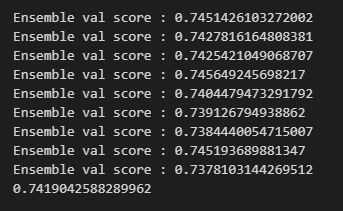

In [28]:
np.mean(scores_total), scores_total

(0.741239073366747,
 [0.7417935846702757,
  0.7360960548968998,
  0.7434291568583405,
  0.7420413711387539,
  0.7449296230304285,
  0.7393761758389744,
  0.7392285899106642,
  0.7387813728205037,
  0.742543048933485,
  0.7441717555691441])

In [29]:
import json

with open("cat_4972_61_params_drop.json", "w") as f:
    json.dump(cat_param_list, f)
with open("lgbm_4972_61_params_drop.json", "w") as f:
    json.dump(lgbm_param_list, f)  

with open("cat_4972_61_params_drop.json", "r") as f:
    loaded_cat_params = json.load(f)
with open("lgbm_4972_61_params_drop.json", "r") as f:
    loaded_lgbm_params = json.load(f)


In [39]:
cat_ratio, lgbm_ratio = 2,1
total_ratio = cat_ratio + lgbm_ratio

scores_ensemble_total = []
test_pred_ensemble_total = []
for i in range(10):
    if i == 1 or i == 7 : continue
    val_pred_cat_seed = val_pred_cat_total[i]
    val_pred_lgbm_seed = val_pred_lgbm_total[i]
    
    test_pred_cat_seed = test_pred_cat_total[i]
    test_pred_lgbm_seed = test_pred_lgbm_total[i]
    
    val_pred_ensemble = (val_pred_cat_seed*cat_ratio + val_pred_lgbm_seed*lgbm_ratio)/total_ratio
    y_val_seed = y_val_total[i]
    roc_val_seed = roc_auc_score(y_val_seed, val_pred_ensemble)
    scores_ensemble_total.append(roc_val_seed)
    print('Ensemble val score : {}'.format(roc_val_seed))
    
    test_pred_ensemble = (test_pred_cat_seed*cat_ratio + test_pred_lgbm_seed*lgbm_ratio)/total_ratio
    test_pred_ensemble_total.append(test_pred_ensemble)
print(np.mean(scores_ensemble_total))

Ensemble val score : 0.7417301650112662
Ensemble val score : 0.7434975343055984
Ensemble val score : 0.7421075261032559
Ensemble val score : 0.7450219223098333
Ensemble val score : 0.7395031886057548
Ensemble val score : 0.7392950387207469
Ensemble val score : 0.7424982017444643
Ensemble val score : 0.7441304901194978
0.7422230083650523


(0.7413516703548163,  
 [0.7416970614740033,  
  0.7360713495827292,  
  0.7436572670087928,  
  0.7423483802072097,  
  0.7450811917576219,  
  0.7391112105138649,  
  0.7395745414603249,  
  0.7393481890328634,  
  0.7427205197515216,  
  0.7439069927592319])  
Ensemble val score : 0.7417583290258765  
Ensemble val score : 0.7436850024073087  
Ensemble val score : 0.7424082452879319  
Ensemble val score : 0.7450999025735123  
Ensemble val score : 0.7391714726832095  
Ensemble val score : 0.7396881405734386  
Ensemble val score : 0.7394793235795449  
Ensemble val score : 0.7426435639764886  
Ensemble val score : 0.7438747809301778  
0.7419787512263876  
**64feature 0.74107**  
**Minsu 0.74121**

#### 재현성 확인

In [64]:
cat_ratio, lgbm_ratio= 2,1
total_ratio = cat_ratio + lgbm_ratio
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total2 = []
scores_total2 = []
seed_everything(seed)

scores_ensemble_total = []
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier()
    model.load_model("./weight/cat_{}_fold_{}.cbm".format(seed, idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]

    val_pred_soft = (val_pred*cat_ratio+ val_pred_lgbm*lgbm_ratio)/total_ratio
    
    roc_val = roc_auc_score(y_val, val_pred_soft)
    scores_total2.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    
    test_pred_soft = (test_pred*cat_ratio+ test_pred_lgbm*lgbm_ratio)/total_ratio
    test_pred_total2.append(test_pred_soft)

Seed 4972 Start!
Ensemble val score : 0.7412874027187021
Ensemble val score : 0.7359910980172637
Ensemble val score : 0.7435771981220689
Ensemble val score : 0.7424202770731925
Ensemble val score : 0.7447806592045985
Ensemble val score : 0.7390228185865049
Ensemble val score : 0.7393987662107062
Ensemble val score : 0.7390029085629748
Ensemble val score : 0.7423530420276374
Ensemble val score : 0.743797138191828


In [56]:
'''(0.7410285683267562,
 [0.7442710570520504,
  0.7332683388845695,
  0.7402746404910163,
  0.7474048789294263,
  0.744503392073965,
  0.7385745928912433,
  0.7373400205386942,
  0.7406626476744791,
  0.7424275715911872,
  0.7415585431409308])'''

'(0.7410285683267562,\n [0.7442710570520504,\n  0.7332683388845695,\n  0.7402746404910163,\n  0.7474048789294263,\n  0.744503392073965,\n  0.7385745928912433,\n  0.7373400205386942,\n  0.7406626476744791,\n  0.7424275715911872,\n  0.7415585431409308])'

Text(0.5, 1.0, 'Feature Importance')

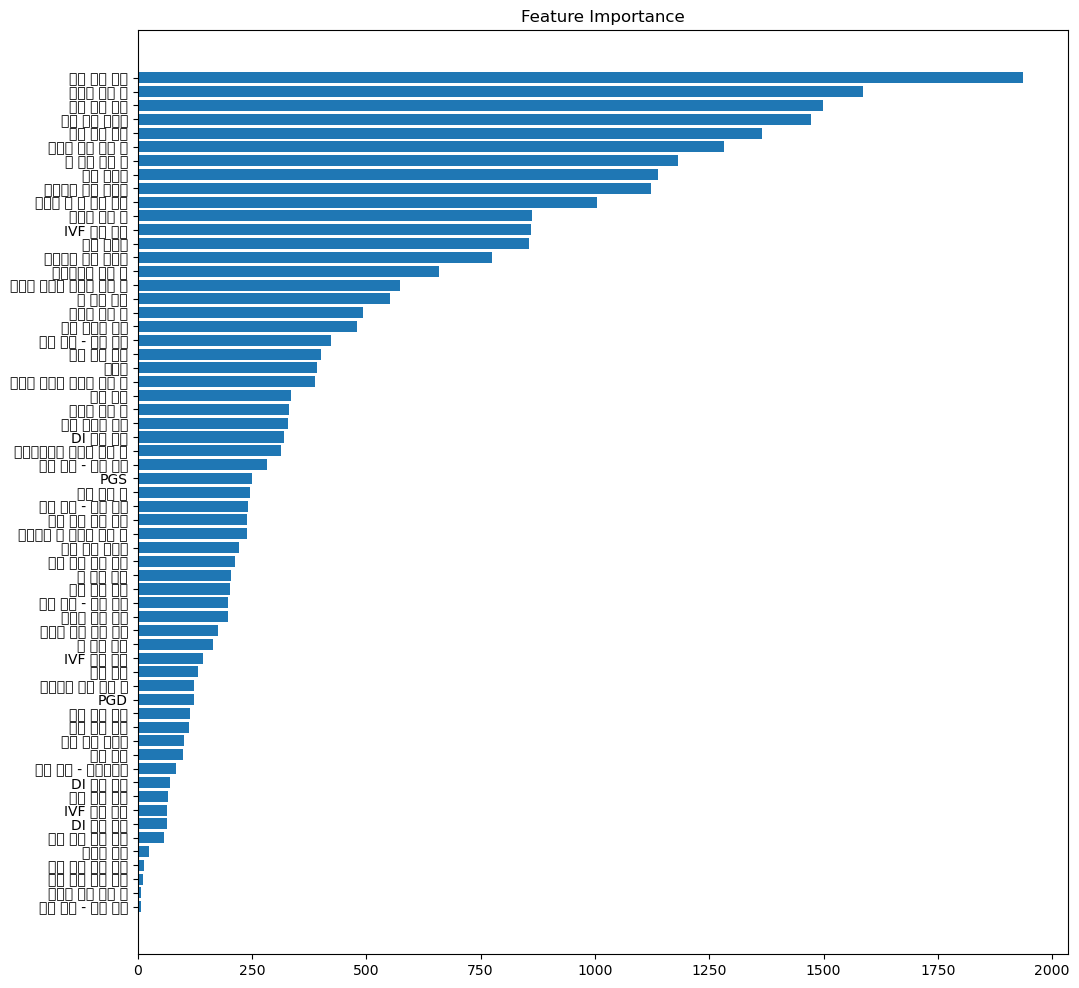

In [33]:
feature_importance = model_lgbm.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')

In [34]:
np.array(X.columns)[sorted_idx][::-1]

array(['시술 당시 나이', '이식된 배아 수', '시술 시기 코드', '배아 이식 경과일', '저장 배아 비율',
       '수집된 신선 난자 수', '총 생성 배아 수', '배아 이식률', '미세주입 배아 생성률',
       '클리닉 내 총 시술 횟수', '혼합된 난자 수', 'IVF 시술 횟수', '임신 성공률', '미세주입 배아 이식률',
       '미세주입된 난자 수', '파트너 정자와 혼합된 난자 수', '총 시술 횟수', '저장된 배아 수',
       '정자 기증자 나이', '불임 원인 - 남성 요인', '특정 시술 유형', '출산율',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '해동된 배아 수', '난자 기증자 나이', 'DI 시술 횟수',
       '미세주입에서 생성된 배아 수', '불임 원인 - 난관 질환', 'PGS', '해동 난자 수',
       '불임 원인 - 여성 요인', '단일 배아 이식 여부', '미세주입 후 저장된 배아 수', '해동 배아 생존율',
       '배아 생성 주요 이유', '총 임신 횟수', '배란 자극 여부', '불임 원인 - 배란 장애', '불명확 불임 원인',
       '파트너 정자 혼합 비율', '총 출산 횟수', 'IVF 임신 횟수', '정자 출처', '미세주입 배아 이식 수',
       'PGD', '여성 불임 원인', '남성 불임 원인', '난자 혼합 경과일', '시술 유형',
       '불임 원인 - 자궁내막증', 'DI 임신 횟수', '부부 불임 원인', 'IVF 출산 횟수', 'DI 출산 횟수',
       '기증 배아 사용 여부', '대리모 여부', '신선 배아 사용 여부', '동결 배아 사용 여부',
       '저장된 신선 난자 수', '불임 원인 - 정자 요인'], dtype=object)

In [40]:
test_pred_total_mean = np.mean(test_pred_ensemble_total, axis=(0))

(array([13540.,  2386.,  3465.,  6300.,  9422., 13408., 16818., 15281.,
         8987.,   460.]),
 array([4.87204976e-04, 8.93422512e-02, 1.78197297e-01, 2.67052344e-01,
        3.55907390e-01, 4.44762436e-01, 5.33617482e-01, 6.22472528e-01,
        7.11327575e-01, 8.00182621e-01, 8.89037667e-01]),
 <BarContainer object of 10 artists>)

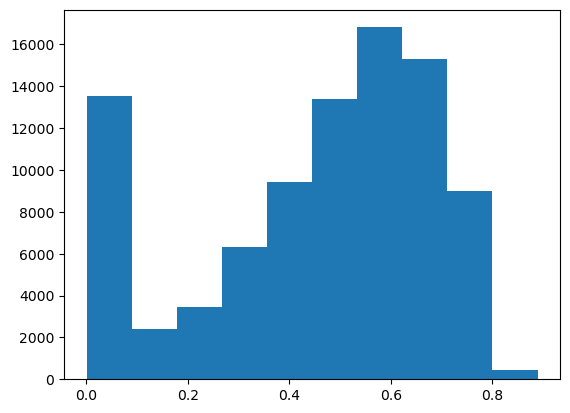

In [41]:
plt.hist(test_pred_total_mean)

In [42]:
sample_submission = pd.read_csv('/work/home/ybchae/aimers/aimers_data/sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean

In [43]:
sample_submission.to_csv('/work/home/ybchae/aimers/aimers_data/seed4972_61_8fold.csv', index=False)

(array([13524.,  2400.,  3325.,  6142.,  9271., 13285., 16861., 15179.,
         9483.,   597.]),
 array([1.41450202e-04, 8.85355551e-02, 1.76929660e-01, 2.65323765e-01,
        3.53717870e-01, 4.42111975e-01, 5.30506080e-01, 6.18900185e-01,
        7.07294290e-01, 7.95688394e-01, 8.84082499e-01]),
 <BarContainer object of 10 artists>)

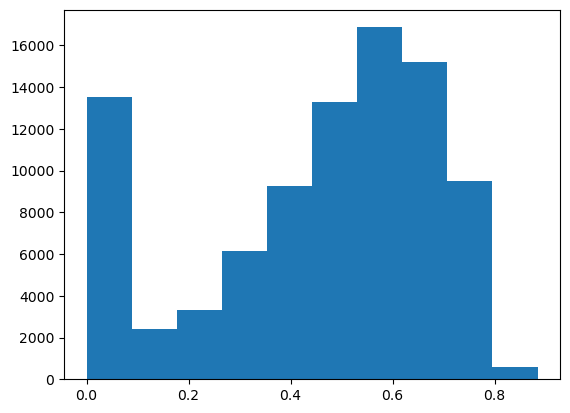

In [44]:
best_submission = pd.read_csv('/work/home/ybchae/aimers/aimers_data/Add_feature_Minsu_seed_trial60_8fold.csv')
plt.hist(best_submission['probability'])